In [1]:
setwd('/home/chenxupeng/projects/exseek')
suppressMessages(library(SingleCellExperiment))
suppressMessages(library(scater))

options(stringsAsFactors = FALSE)

# To Do
- [ ]ensure input file format is correct
- [ ]determine label information ( which class)
- [ ]path 
- [ ]function for filter 
- [ ]top k threshold
- [x]combat batch removal log and reverse
- [ ]cpm，remove pi、mi，top20，reference gene to R
- [ ]RUVs use or not use class info
- [ ]alignment score(python)
- [ ]scnorm and ruvs plot

filename, savename, use which operation, pipeline
- Imputation
    - scImpute
- Normalization
    - CPM
    - Top20
    - Remove pi, miRNA
    - TMM
    - RLE
    - SCNorm
- Batch Removal
    - RUVs: need logged normalization matrix
    - Combat: need logged normalization matrix

# load data

In [2]:
matrix_path = 'data/expression_matrix/scirep_sequential_qc.txt'
classinfo_path = 'data/labels/scirep_classes.txt'

In [3]:
m <- read.csv(matrix_path, sep='\t',row.names = 1, header=TRUE)

In [4]:
sample_info <-read.csv(classinfo_path)
head(sample_info)

sample_id,label
Sample_1S3,Colorectal Cancer
Sample_1S6,Colorectal Cancer
Sample_1S9,Colorectal Cancer
Sample_1S12,Colorectal Cancer
Sample_1S15,Colorectal Cancer
Sample_1S18,Colorectal Cancer


In [5]:
print (dim(m))
print (dim(sample_info))
head(m)

[1] 89619   191
[1] 191   2


,Sample_1S10,Sample_1S11,Sample_1S12,Sample_1S13,Sample_1S14,Sample_1S15,Sample_1S16,Sample_1S17,Sample_1S18,Sample_1S19,⋯,Sample_PC34,Sample_PC35,Sample_PC36,Sample_PC3,Sample_PC4,Sample_PC5,Sample_PC6,Sample_PC7,Sample_PC8,Sample_PC9
ENST00000473358.1|MIR1302-2HG-202|1544,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENST00000469289.1|MIR1302-2HG-201|843,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENST00000466430.5|AL627309.1-201|31638,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0
ENST00000471248.1|AL627309.1-203|18221,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENST00000610542.1|AL627309.1-205|12999,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENST00000493797.1|AL627309.2-201|550,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


# filter lowly expressed reads

In [6]:
thres_count = 2
thres_sample_nums = 5
keep_feature <- rowSums(m > thres_count) > thres_sample_nums
m <- m[keep_feature, ]
dim(m)

[1] 7936  191

In [7]:
reads <- SingleCellExperiment(
    assays = list(counts = as.matrix(m)),
    colData = sample_info )
reads

class: SingleCellExperiment 
dim: 7936 191 
metadata(0):
assays(1): counts
rownames(7936): ENST00000591702.1|AL669831.5-218|1873
  ENST00000609207.1|AL645608.1-201|4152 ...
  ENST00000363702.1|Y_RNA.163-201|113
  ENST00000362554.1|Y_RNA.28-201|111
rowData names(0):
colnames(191): Sample_1S10 Sample_1S11 ... Sample_PC8 Sample_PC9
colData names(2): sample_id label
reducedDimNames(0):
spikeNames(0):

In [8]:
reads <-  calculateQCMetrics(reads)

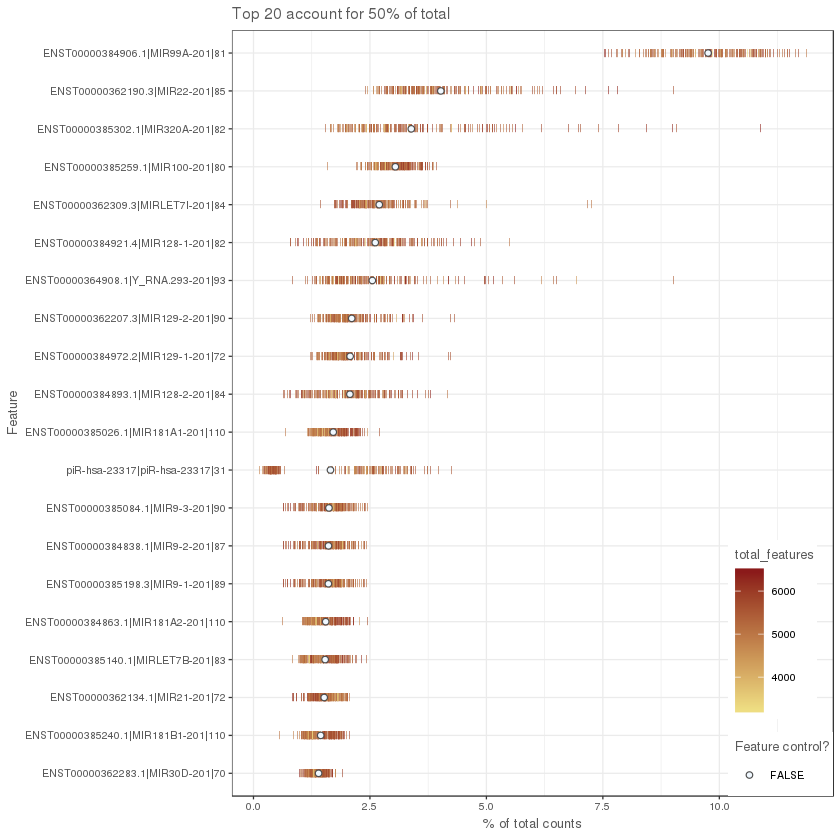

In [9]:
plotHighestExprs(reads,n=20)

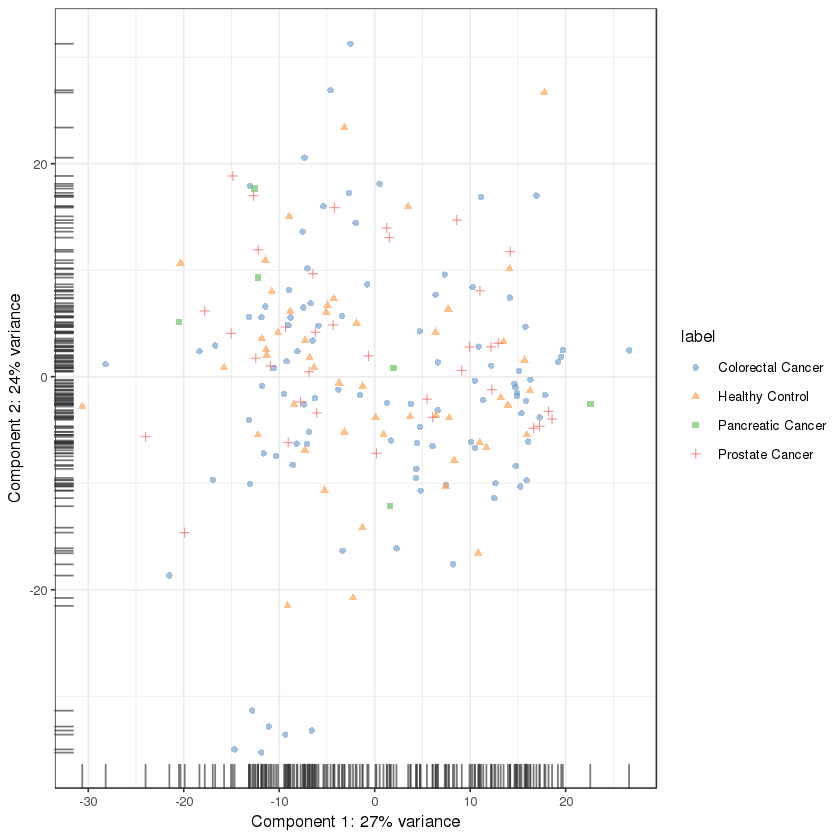

In [10]:
plotPCA(
    reads,
    exprs_values = "counts",
    shape_by = "label",
    colour_by = "label"
)

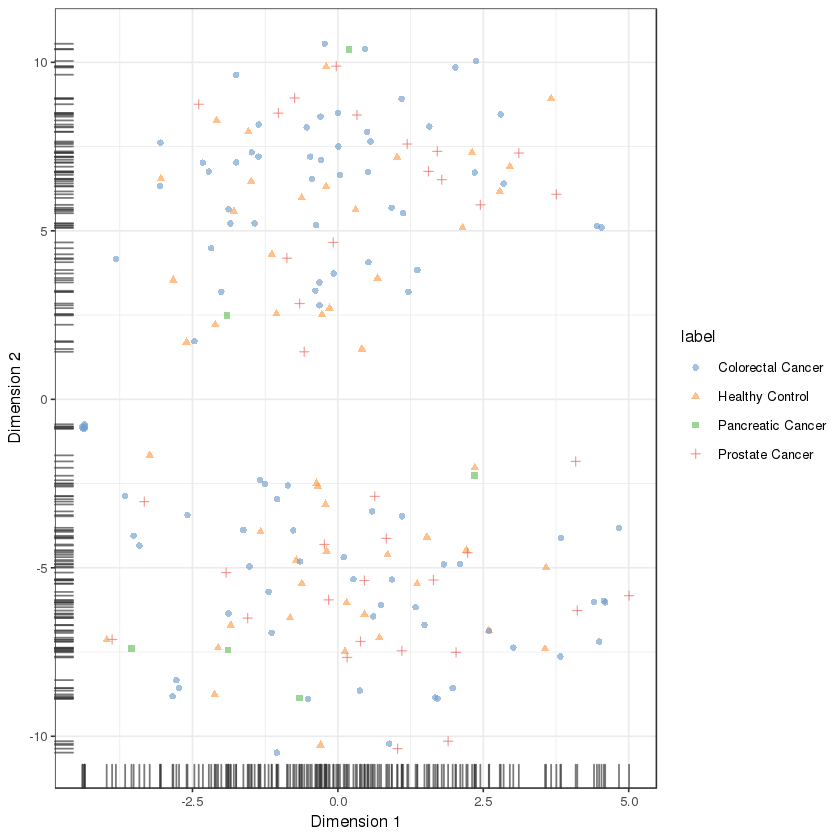

In [11]:
plotTSNE(
    reads,
    exprs_values = "counts",
    shape_by = "label",
    colour_by = "label"
)

# imputation
using scImpute

In [12]:
suppressMessages(library("scImpute"))

In [13]:
sampleLables <- c()
for(i in colnames(reads)){tmp <- as.character(sample_info[which(sample_info$sample_id==i),"label"]); sampleLables <- c(sampleLables,tmp)}

In [14]:
write.csv(counts(reads), "data/expression_matrix/tmpsave.csv")

In [16]:
scimpute(count_path = "data/expression_matrix/tmpsave.csv", infile = "csv", 
         outfile = "txt", out_dir = "data/matrix_processing/imputation/", Kcluster = 5, ncores = 3, labels = as.vector(sampleLables), labeled = TRUE)

[1] "reading in raw count matrix ..."
[1] "number of genes in raw count matrix 7936"
[1] "number of cells in raw count matrix 191"
[1] "estimating dropout probability for type 1 ..."
[1] "imputing dropout values for type 1 ..."
[1] "estimating dropout probability for type 2 ..."
[1] "imputing dropout values for type 2 ..."
[1] "estimating dropout probability for type 3 ..."
[1] "imputing dropout values for type 3 ..."
[1] "estimating dropout probability for type 4 ..."
[1] "imputing dropout values for type 4 ..."
[1] "writing imputed count matrix ..."


integer(0)

# Normalization

## SCnorm

In [17]:
library('SCnorm')

Setting up parallel computation using 4 cores
Gene filter is applied within each condition.
0 genes in condition 1 will not be included in the normalization due to 
             the specified filter criteria.
A list of these genes can be accessed in output, 
    see vignette for example.
Finding K for Condition 1
Trying K = 1
Trying K = 2
Trying K = 3


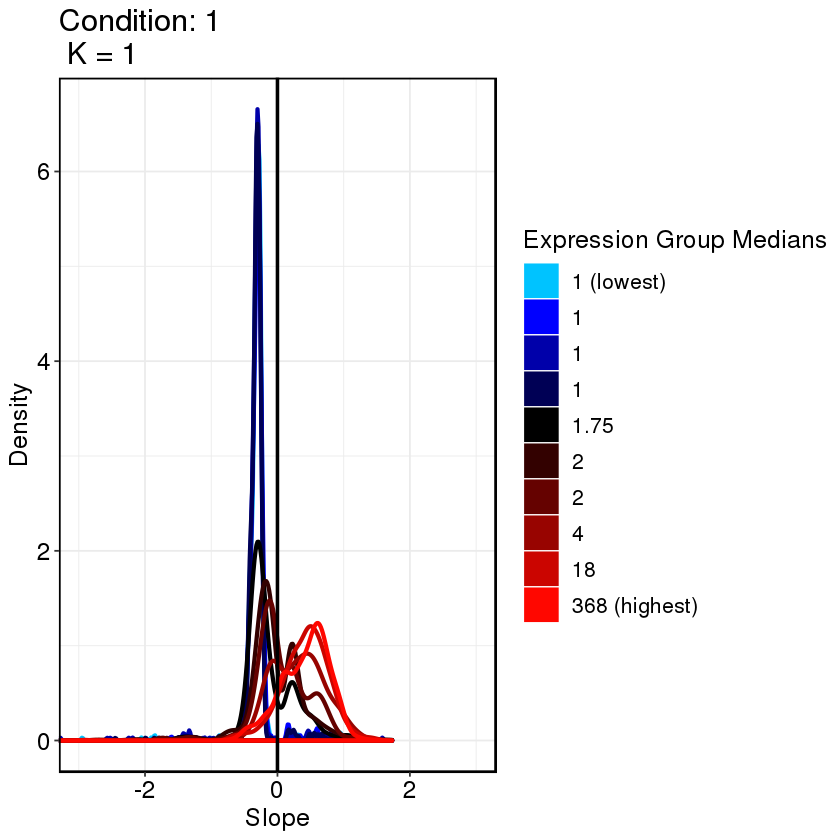

Trying K = 4


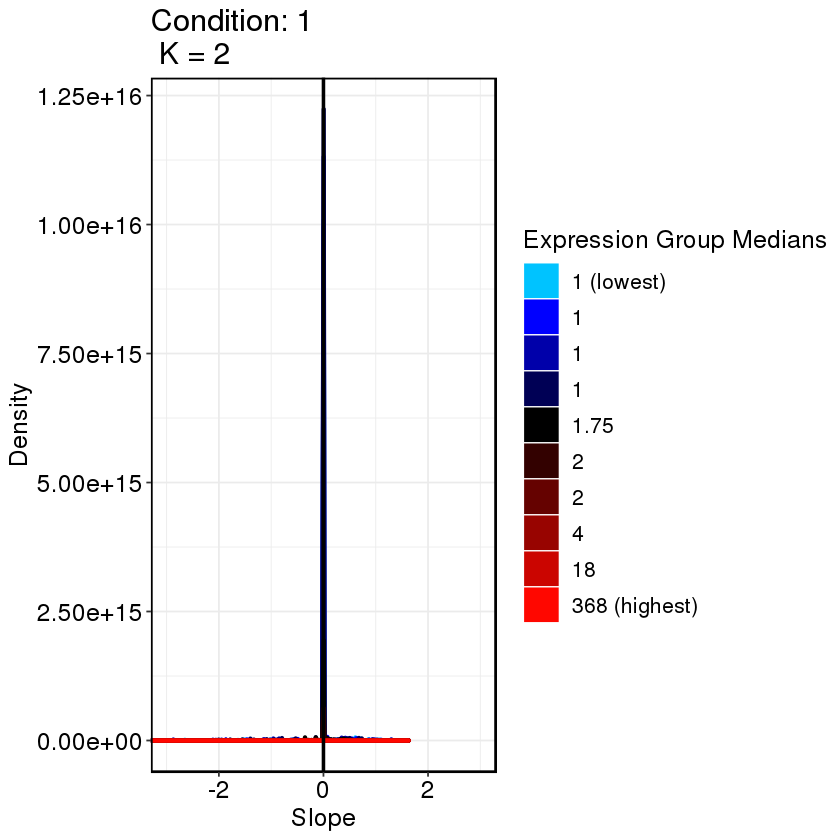

Trying K = 5


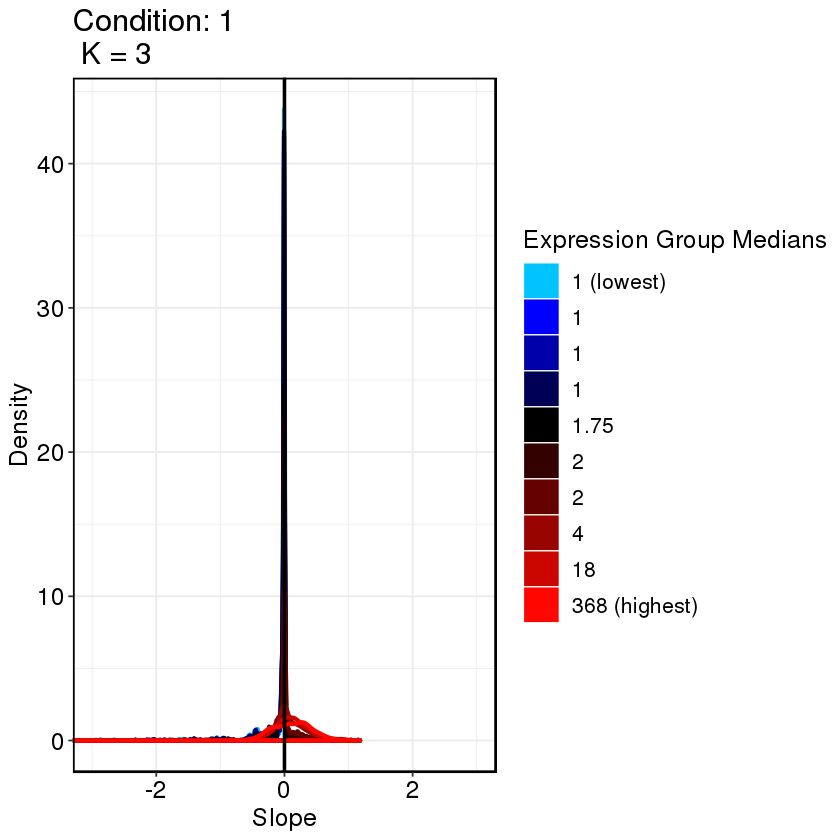

Trying K = 6


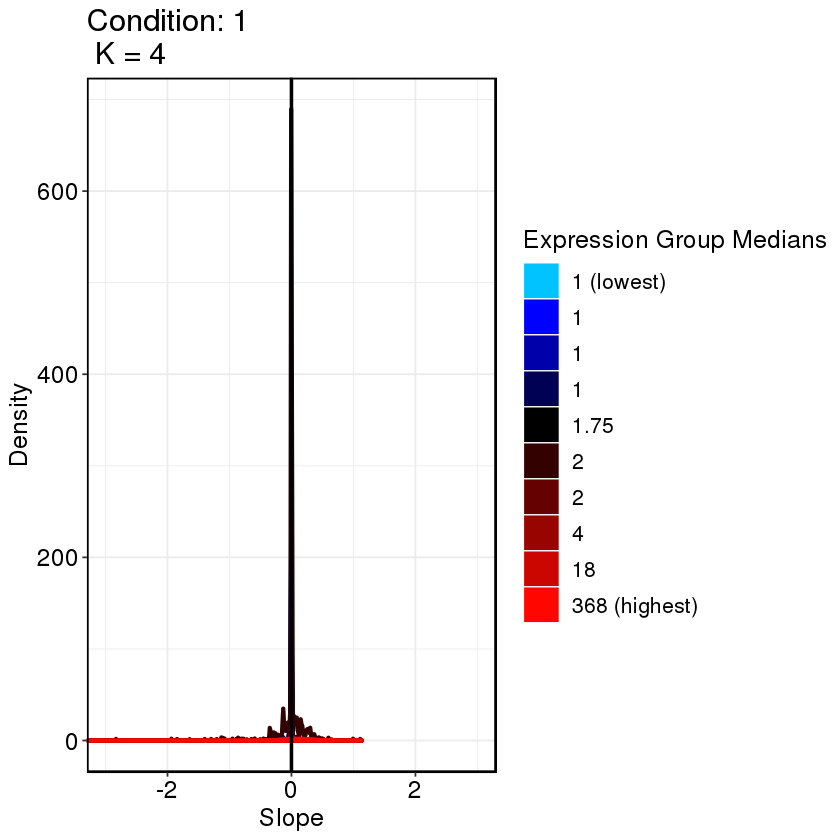

Trying K = 7


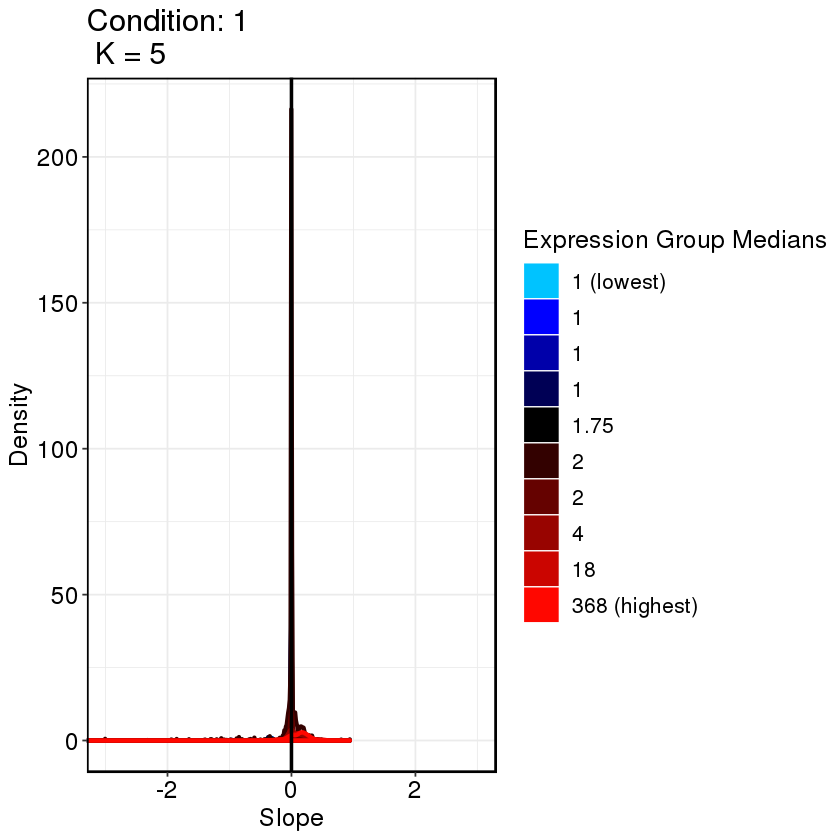

Done!


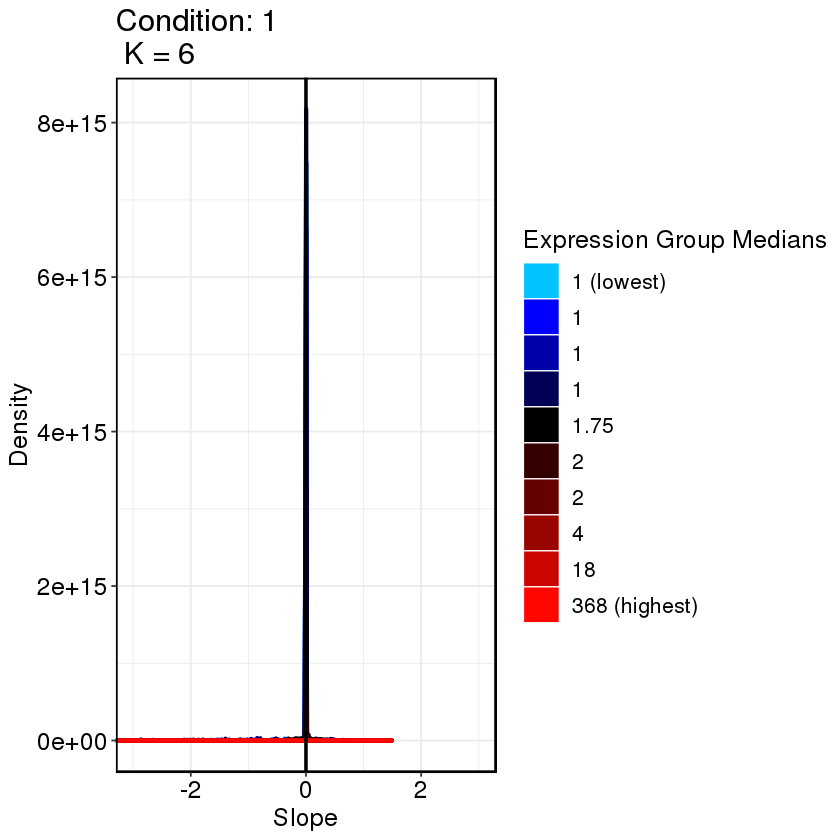

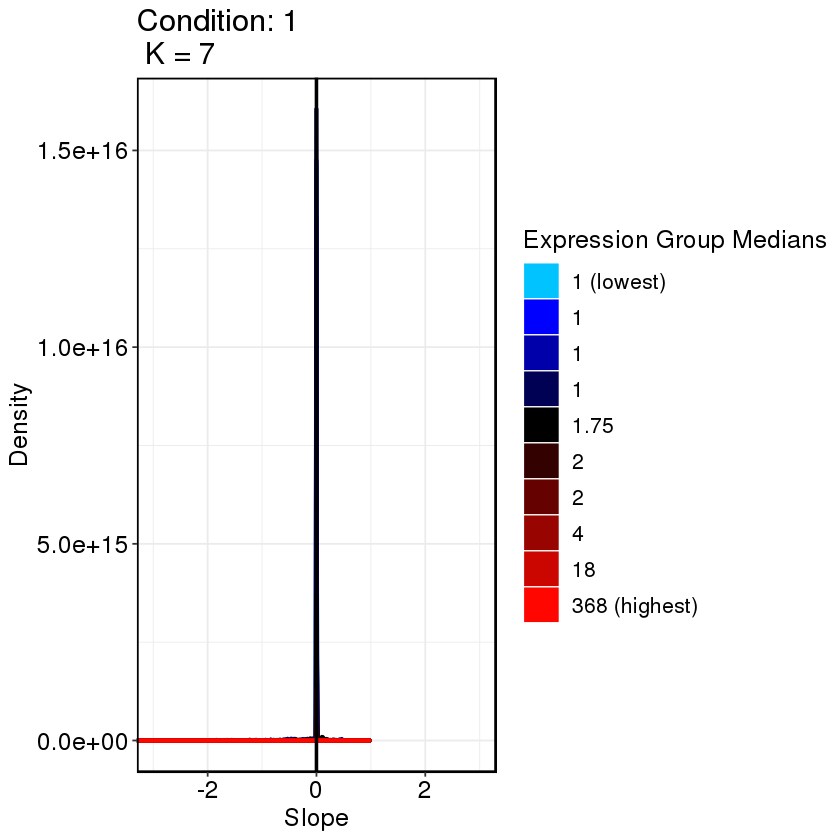

In [18]:
Conditions = rep(1, dim(m)[2])
DataNorm <- SCnorm(Data = m, Conditions = Conditions, PrintProgressPlots = TRUE, NCores = 4)
NormalizedData <- results(DataNorm)

In [19]:
savename = 'data/matrix_processing/normalization/scirep_scnorm.txt'

In [20]:
write.table(NormalizedData, file=savename, sep='\t', quote=FALSE, row.names=TRUE, col.names=TRUE)

## TMM

In [21]:
reads_tmm <- normaliseExprs(reads, method = "TMM")

## normalize the object using the saved size factors
reads_tmm <- normalize(reads_tmm)

In [22]:
savename = 'data/matrix_processing/normalization/scirep_tmm.txt'
write.table(normcounts(reads_tmm), file=savename, sep='\t', quote=FALSE, 
            row.names=TRUE, col.names=TRUE)

## RLE

In [23]:
reads_rle <- normaliseExprs(reads, method = "RLE")

## normalize the object using the saved size factors
reads_rle <- normalize(reads_rle)
savename = 'data/matrix_processing/normalization/scirep_rle.txt'
write.table(normcounts(reads_rle), file=savename, sep='\t', quote=FALSE, 
            row.names=TRUE, col.names=TRUE)

## CPM total

scirepdata_cpm = scirepdata*10e6/scirepdata.sum(axis=0)

## CPM  top k as factor

k = 20
features_top = scirepdata[np.argsort(-scirepdata.sum(axis=1))[:k]]  # find top k feature
scirepdata_cpm_top = scirepdata*10e6/features_top.sum(axis=0)

## remove mi and pirna and use CPM

geneannotation = pd.read_table('/Share/home/shibinbin/projects/exRNA/data/annotation/transcript_table/all.txt')
gsegeneid = np.array([ scirepcount.index[i].split('|')[0] for i 
                      in range(scirepcount.index.shape[0]) ])
geneannotation.index = geneannotation['transcript_id']
gsecount_anno = geneannotation.loc[gsegeneid]
removeind = np.concatenate((np.where(gsecount_anno['gene_type'] =='miRNA')[0],
                np.where(gsecount_anno['gene_type'] =='piRNA')[0]))
removed_scirepcount = scirepcount.iloc[np.delete(np.arange(0,scirepcount.shape[0]),removeind)]

## CPM reference gene

### show reference gene's stability 
- violin plot of variance coefficient
- density plot

def plot_reference_cv_comparison(table,dataname,wholetable,normalize=True):
    fig,ax=plt.subplots(figsize=(6,6))
    nonnan = np.where(np.sum(pd.isna(table),axis=1)==0)[0] 
    #print (nonnan)
    table = table.iloc[nonnan,:]
    table_log =  np.log2(table+1)
    cv = np.std(table_log,axis=1)/np.mean(table_log,axis=1)
    
    table_log_whole = np.log2(wholetable+1)
    cv_whole = np.std(table_log_whole,axis=1)/np.mean(table_log_whole,axis=1)
    tablenew1 = pd.DataFrame(np.concatenate((np.repeat('reference',cv.shape[0]),np.repeat('others',cv_whole.shape[0]))).reshape(-1,1))
    tablenew2 = pd.DataFrame(np.concatenate((cv,cv_whole)).reshape(-1,1))
    tablenew = pd.concat((tablenew1,tablenew2),axis=1)   
    tablenew.columns = ['Genes','Coefficient of Variation']  
    #tablenew  = pd.to_numeric(tablenew.iloc[:,1])
    sns.violinplot(data =tablenew,x='Genes',y = 'Coefficient of Variation',ax=ax)
    ax.set_title(dataname+ 'Reference genes')
def plot_reference_density(table,dataname,wholetable,normalize=True):
    fig,ax=plt.subplots(figsize=(10,6))
    nonnan = np.where(np.sum(pd.isna(table),axis=1)==0)[0] 
    #print (nonnan)
    table = table.iloc[nonnan,:]
    table_log =  np.log2(table+1)
    cv = np.std(table_log,axis=1)/np.mean(table_log,axis=1)
    
    table_log_whole = np.log2(wholetable+1)
    cv_whole = np.std(table_log_whole,axis=1)/np.mean(table_log_whole,axis=1)
    sns.kdeplot(cv_whole, shade=True)
    cv = np.sort(cv)
    for tick in cv:
        ax.axvline(x=tick, color='g',linewidth=0.4, linestyle='--')
    #if dataname = 'HCCLulab ':
    #for i in range(cv.shape[0]):
    #    ax.text(cv[i], 0.1+i*0.03, np.round(cv[i],2), 
    #        horizontalalignment='center', size='x-small', color='b', weight='semibold')
    ax.set_title(dataname+ 'Reference genes')

reference_transcript_id = np.array([
          'ENST00000385271.1|MIR16-1-201|89','ENST00000607334.3|MIR15A-201|83',
          'ENST00000385059.1|MIR451A-201|72','ENST00000362134.1|MIR21-201|72',
          'ENST00000385245.1|MIR23A-201|73','ENST00000362117.1|MIR16-2-201|81',
           'ENST00000384832.1|MIR23B-201|97','ENST00000579846.3|MIR23C-201|100'])
referencegene_peak = np.array(['peak_1193|MIR1228-201|miRNA','peak_665|MIR16-1-201|miRNA',
          'peak_1061|MIR16-1-201|miRNA','peak_1025|MIR15A-201|miRNA','peak_1804|MIR15A-201|miRNA',
          'peak_618|MIR451A-201|miRNA','peak_1002|MIR451A-201|miRNA','peak_655|MIR23A-201|miRNA',
          'peak_1049|MIR23A-201|miRNA','peak_609|MIR15B-201|miRNA',
          'peak_186|MIR16-2-201|miRNA','peak_402|MIR16-2-201|miRNA','peak_534|MIR23B-201|miRNA',
          'peak_898|MIR23B-201|miRNA'])
def get_normalized_reference(table,table_reference):
     return table[table_reference.columns]*1e6/np.sum(table_reference,axis=0)
gsecount = pd.read_csv('data/expression_matrix/scirep_sequential_qc.txt',sep='\t',index_col=0)
gsecount_reference = gsecount.loc[reference_transcript_id]
get_normalized_reference(gsecount,gsecount_reference).to_csv(
    'data/normalization/reference.scirep_sequential_qc.txt',sep='\t')

# 因为我们要做full length和peak两种数据，所以reference也分成full length和peak两种

#  Batch removal

## show batch effect

In [25]:
# use boxplot, x axis: batch, y axis: counts

## ruvs

In [26]:
suppressMessages(library(EDASeq))
suppressMessages(library(RUVSeq))
suppressMessages(library(sva))
suppressMessages(library(scRNA.seq.funcs))

- [ ]需要先取log，最后变换回去！！！

In [27]:
# RUVs uses centered (technical) replicate/negative control samples for which the covariates of interest are constant
scIdx <- matrix(-1, ncol = max(table(sample_info$label)), nrow = 2)
tmp <- which(sample_info$label == "Colorectal Cancer")
scIdx[1, 1:length(tmp)] <- tmp
tmp <- which(sample_info$label == "Healthy Control")
#scIdx[2, 1:length(tmp)] <- tmp  #给label信息
scIdx[1, 1:length(tmp)] <- tmp #不给label信息
cIdx <- rownames(m)

In [28]:
ruvs <- RUVs(as.matrix(m), cIdx, k = 10, scIdx = scIdx, isLog = TRUE) #k可调节

In [29]:
savename = 'data/matrix_processing/batch_removal/nolabel.ruvs.scirep.txt'

In [30]:
write.table(ruvs$normalizedCounts, file=savename, sep='\t', quote=FALSE, 
            row.names=TRUE, col.names=TRUE)

null device 
          1

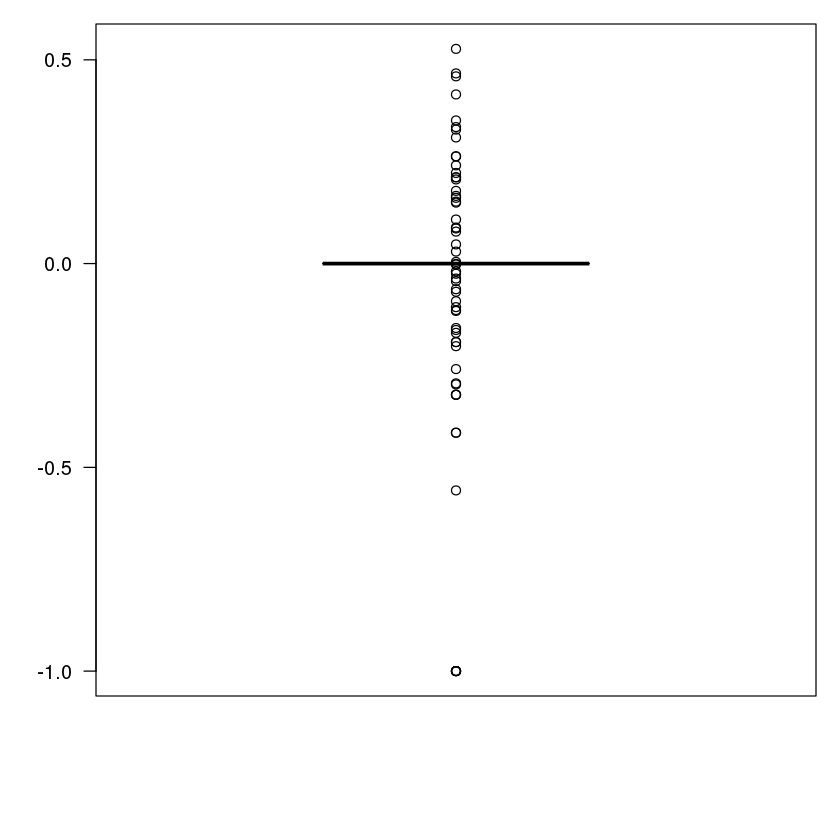

In [31]:
res <- list()
for(n in assayNames(reads)) {
    res[[n]] <- suppressWarnings(calc_cell_RLE(assay(reads, n)))
}
par(mar=c(6,4,1,1))
boxplot(res, las=2)
dev.off()

## combat

- [ ]多种batch信息的时候分别给出结果

In [32]:
batch_info <-read.csv('data/other_annotations/scirep_batch.txt',sep=',',row.names=1)

In [33]:
head(batch_info)

,RNA.Isolation.batch,library.prepration.day,gel.cut.size.selection
Sample_1S1,2,22,7
Sample_1S2,2,22,8
Sample_1S3,2,22,1
Sample_2S1,2,22,2
Sample_2S2,2,22,3
Sample_2S3,2,22,4


In [34]:
colnames(batch_info)[1]

[1] "RNA.Isolation.batch"

In [35]:
combat_data <- log(m+0.001)
mod_data <- as.data.frame(t(combat_data))
# Basic batch removal
mod0 = model.matrix(~ 1, data = mod_data) 
# Preserve biological variability
mod1 = model.matrix(~ sample_info$label, data = mod_data) 

In [36]:
head(combat_data)

,Sample_1S10,Sample_1S11,Sample_1S12,Sample_1S13,Sample_1S14,Sample_1S15,Sample_1S16,Sample_1S17,Sample_1S18,Sample_1S19,⋯,Sample_PC34,Sample_PC35,Sample_PC36,Sample_PC3,Sample_PC4,Sample_PC5,Sample_PC6,Sample_PC7,Sample_PC8,Sample_PC9
ENST00000591702.1|AL669831.5-218|1873,0.0009995003,-6.907755,0.0009995003,1.3865443299,0.0009995003,-6.9077552790,-6.9077553,-6.9077552790,0.0009995003,-6.9077552790,⋯,-6.907755,-6.907755,0.0009995003,-6.9077552790,-6.9077552790,-6.9077552790,-6.9077552790,-6.9077552790,-6.907755,-6.9077553
ENST00000609207.1|AL645608.1-201|4152,-6.9077552790,-6.907755,-6.9077552790,-6.9077552790,-6.9077552790,0.0009995003,-6.9077553,1.3865443299,0.0009995003,-6.9077552790,⋯,-6.907755,-6.907755,-6.9077552790,-6.9077552790,1.0989455665,0.0009995003,0.6936470556,0.0009995003,-6.907755,-6.9077553
ENST00000442292.2|AL645608.9-201|1081,0.0009995003,1.386544,0.6936470556,0.0009995003,0.0009995003,0.0009995003,0.6936471,0.6936470556,-6.9077552790,0.0009995003,⋯,-6.907755,-6.907755,-6.9077552790,0.0009995003,0.0009995003,0.0009995003,0.0009995003,2.5650262776,2.484990,0.6936471
ENST00000607307.1|AL391244.3-201|1523,-6.9077552790,-6.907755,-6.9077552790,-6.9077552790,-6.9077552790,-6.9077552790,-6.9077553,0.0009995003,-6.9077552790,-6.9077552790,⋯,-6.907755,-6.907755,-6.9077552790,-6.9077552790,-6.9077552790,0.0009995003,-6.9077552790,-6.9077552790,-6.907755,-6.9077553
ENST00000366221.3|AL645728.1-201|2101,-6.9077552790,-6.907755,0.0009995003,-6.9077552790,0.0009995003,-6.9077552790,-6.9077553,-6.9077552790,-6.9077552790,-6.9077552790,⋯,-6.907755,-6.907755,-6.9077552790,-6.9077552790,-6.9077552790,-6.9077552790,-6.9077552790,-6.9077552790,-6.907755,-6.9077553
ENST00000598846.1|AL031282.2-201|34953,1.6096378924,1.791926,2.3979861778,-6.9077552790,1.0989455665,1.7919261220,1.0989456,1.9460529960,0.6936470556,1.7919261220,⋯,1.386544,-6.907755,1.0989455665,2.5650262776,3.1355376932,3.2958739024,2.7081168655,2.5650262776,2.197336,1.7919261


In [37]:
combat <- ComBat(
    dat = t(mod_data), 
    batch = factor(batch_info[,1]), 
    mod = mod1,
    par.prior = TRUE,
    prior.plots = FALSE
)

Found9batches
Adjusting for3covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



In [38]:
head(exp(combat))

,Sample_1S10,Sample_1S11,Sample_1S12,Sample_1S13,Sample_1S14,Sample_1S15,Sample_1S16,Sample_1S17,Sample_1S18,Sample_1S19,⋯,Sample_PC34,Sample_PC35,Sample_PC36,Sample_PC3,Sample_PC4,Sample_PC5,Sample_PC6,Sample_PC7,Sample_PC8,Sample_PC9
ENST00000591702.1|AL669831.5-218|1873,0.5392986244,0.0007188234,5.392986e-01,2.0344621867,0.5392986244,0.0007188234,0.0007188234,0.0007188234,0.5392986244,0.0007188234,⋯,0.0009910109,0.0009910109,0.957091129,9.910109e-04,0.000989211,0.001537255,0.001537255,0.001581721,0.0014717893,0.0014717893
ENST00000609207.1|AL645608.1-201|4152,0.0015251022,0.0015251022,1.525102e-03,0.0015251022,0.0015251022,1.6484688195,0.0015251022,6.6911853964,1.6484688195,0.0015251022,⋯,0.0025005915,0.0025005915,0.002500591,2.500591e-03,13.013583779,0.341971790,0.627029048,0.322167338,0.0005171264,0.0005171264
ENST00000442292.2|AL645608.9-201|1081,0.5769533664,2.3818541865,1.172121e+00,0.5769533664,0.5769533664,0.5769533664,1.1721210093,1.1721210093,0.0004905677,0.5769533664,⋯,0.0029600129,0.0029600129,0.002960013,3.095787e+00,3.086248044,1.013334472,1.013334472,10.999617040,9.8296851173,1.6409306260
ENST00000607307.1|AL391244.3-201|1523,0.0008206923,0.0008206923,8.206923e-04,0.0008206923,0.0008206923,0.0008206923,0.0008206923,0.3865224037,0.0008206923,0.0008206923,⋯,0.0011409771,0.0011409771,0.001140977,1.140977e-03,0.001137009,2.053943881,0.001349460,0.001480613,0.0010930775,0.0010930775
ENST00000366221.3|AL645728.1-201|2101,0.0009498212,0.0009498212,1.274436e+00,0.0009498212,1.2744363822,0.0009498212,0.0009498212,0.0009498212,0.0009498212,0.0009498212,⋯,0.0011399379,0.0011399379,0.001139938,1.139938e-03,0.001171382,0.001961491,0.001961491,0.001948338,0.0012078975,0.0012078975
ENST00000598846.1|AL031282.2-201|34953,4.8493546518,5.9124312692,1.142790e+01,0.0004607938,2.7830383062,5.9124312692,2.7830383062,6.9911657313,1.7911198670,5.9124312692,⋯,5.1936956032,0.0069596790,4.129155424,1.329432e+01,21.478432360,30.595641460,18.870525122,13.470882298,6.1423901878,3.1435073882


In [39]:
savename = 'data/matrix_processing/batch_removal/combat.batch_1.txt'
write.table(exp(combat), file=savename, sep='\t', quote=FALSE, 
            row.names=TRUE, col.names=TRUE)

Warning message in plotExplanatoryVariables(object, ...):
“variable Class not found in colData(object).
                     Please make sure colData(object)[, variable] exists. This variable will not be plotted.”Warning message in plotExplanatoryVariables(object, ...):
“variable RNA.Isolation.batch not found in colData(object).
                     Please make sure colData(object)[, variable] exists. This variable will not be plotted.”Warning message in plotExplanatoryVariables(object, ...):
“variable library.prepration.day not found in colData(object).
                     Please make sure colData(object)[, variable] exists. This variable will not be plotted.”Warning message in plotExplanatoryVariables(object, ...):
“variable gel.cut.size.selection not found in colData(object).
                     Please make sure colData(object)[, variable] exists. This variable will not be plotted.”

null device 
          1

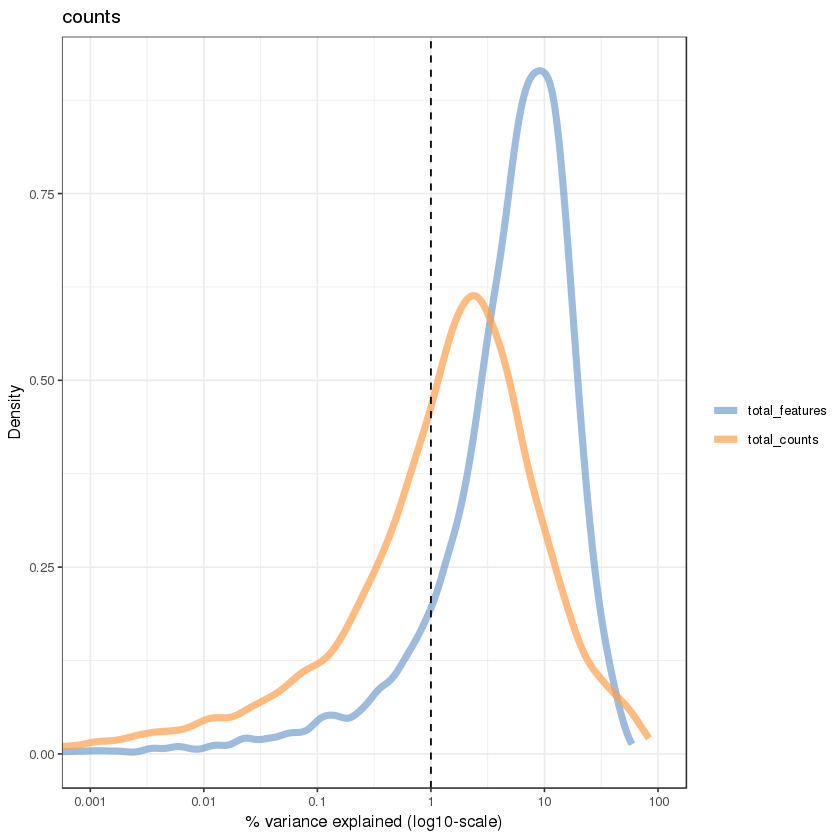

In [41]:
for(n in assayNames(reads)) {
    print(
        plotQC(
            reads,
            type = "expl",
            exprs_values = n,
            variables = c(
                "total_features",
                "total_counts",
                "Class",
                'RNA.Isolation.batch',
                'library.prepration.day',
                'gel.cut.size.selection'
            )
        ) +
        ggtitle(n)
    )
}
dev.off()

# alignment score

def alignment_score(X, y, K=10):
    N = X.shape[0]
    nn = NearestNeighbors(K)
    nn.fit(X)
    distances, indices = nn.kneighbors(X, K + 1)
    neighbor_classes = np.take(y, indices[:, 1:])
    same_class_fractions = np.sum(neighbor_classes == y[:, np.newaxis], axis=1)
    score = 1.0 - (np.mean(same_class_fractions) - K/N)/(K - K/N)
    print (same_class_fractions.shape,np.mean(same_class_fractions),K/N,neighbor_classes)
    return score
def knn_score(X, y, K=10):
    N = X.shape[0]
    assert K < N
    nn = NearestNeighbors(K)
    nn.fit(X)
    
    distances, indices = nn.kneighbors(X, K + 1)
    neighbor_classes = np.take(y, indices[:, 1:])
    same_class_fractions = np.sum(neighbor_classes == y[:, np.newaxis], axis=1)
    
    classes, counts = np.unique(y, return_counts=True)
    classes = np.argmax(y.reshape((-1, 1)) == classes.reshape((1, -1)), axis=1)
    counts = np.take(counts, classes)
    mean_r = K/(N - 1)*counts
    max_r = np.minimum(K, counts)
    #print (same_class_fractions.shape,mean_r.shape,max_r.shape)
    #scores = (np.mean(same_class_fractions) - mean_r)/(max_r - mean_r)
    scores = (same_class_fractions - mean_r)/(max_r - mean_r)
    #print(scores)
    return scores.mean()